In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from nltk.corpus import stopwords

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv('train_data.csv', encoding='utf', engine='python', index_col=0)
test = pd.read_csv('test_data.csv', encoding='utf', engine='python', index_col=0)

Кредит                         0.381816
Вклад                          0.144137
Ипотека                        0.114523
Бизнес услуги                  0.100754
Обслуживание физ. и юр. лиц    0.090700
Дебетовая карта                0.078024
Реструктуризация               0.058791
Денежные переводы              0.022730
Инвестиционные продукты        0.008524
Name: type, dtype: float64

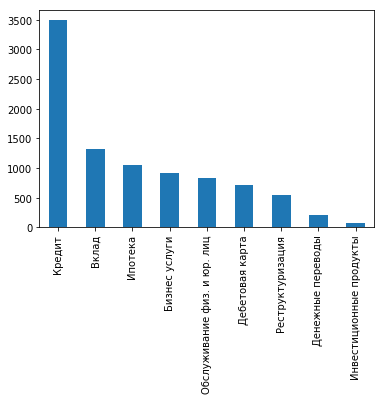

In [3]:
display(train.type.value_counts()/train.type.shape)
train.type.value_counts().plot.bar()

In [4]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [5]:

def text_cleaner(text):
    # к нижнему регистру
    text = text.lower()
    
    # оставляем в предложении только русские буквы (таким образом
    # удалим и ссылки, и имена пользователей, и пунктуацию и т.д.)
    alph = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
    
    cleaned_text = ''
    for char in text:
        if (char.isalpha() and char[0] in alph) or (char == ' '):
            cleaned_text += char
        
    result = []
    for word in cleaned_text.split():
        # лемматизируем
        result.append(morph.parse(word)[0].normal_form)
                              
    return ' '.join(result)

In [6]:
train_title_text = train
train_title_text['text'] = train['title'] + ' . ' + train['text']
train_title_text.head()

,type,title,text
0,Кредит,Просьба об отмене штрафа КАСКО,Просьба об отмене штрафа КАСКО . Здравствуйте!...
1,Ипотека,"В целом хорошо, работали по ипотеке.","В целом хорошо, работали по ипотеке. . Брала ..."
2,Реструктуризация,Нас всегда выручает банк Уралсиб!,Нас всегда выручает банк Уралсиб! . Знакомство...
3,Вклад,Абсолютно неприемлемая ситуация и ее решение,Абсолютно неприемлемая ситуация и ее решение ....
4,Кредит,Внёс не туда,Внёс не туда . Пришёл оплачивать кредит и ошиб...


In [7]:
train['text'] = train['text'].apply(text_cleaner)
train.to_csv('cleaned_train_title_data.csv')
test['text'] = test['text'].apply(text_cleaner)
test.to_csv('cleaned_test_title_data.csv')

In [8]:
test_title_text = test
test_title_text['text'] = test['title'] + ' . ' + test['text']
test_title_text.head()

,title,text
0,Благодарность менеджеру по продажам,Благодарность менеджеру по продажам . хотеться...
1,Брал рассрочку в магазине Самсунг,Брал рассрочку в магазине Самсунг . здравствуй...
2,Тинькофф оказался лучшим,Тинькофф оказался лучшим . работать с они уже ...
3,Недавно открыла расчетный счет в Тинькофф Банке,Недавно открыла расчетный счет в Тинькофф Банк...
4,Волею судеб у меня появилась кредитная карта С...,Волею судеб у меня появилась кредитная карта С...


In [9]:
train_title_text = pd.read_csv('cleaned_train_title_data.csv', index_col=0).dropna()
test_title_text = pd.read_csv('cleaned_test_title_data.csv', index_col=0)

In [36]:
t = pd.DataFrame(test_title_text['title'].isnull())
a = t[t['title'] == True]
list_eng = a.index.tolist()
for i in list_eng:
    test_title_text['title'][i] ='a' 

a []


In [31]:
train_title_text.head()

,type,title,text
0,Кредит,Просьба об отмене штрафа КАСКО,просьба о отмена штраф каско здравствовать год...
1,Ипотека,"В целом хорошо, работали по ипотеке.",в целое хорошо работать по ипотека брать ипоте...
2,Реструктуризация,Нас всегда выручает банк Уралсиб!,мы всегда выручать банк уралсиб знакомство с б...
3,Вклад,Абсолютно неприемлемая ситуация и ее решение,абсолютно неприемлемый ситуация и она решение ...
4,Кредит,Внёс не туда,внести не туда прийти оплачивать кредит и ошиб...


In [10]:
test_title_text.shape

(2750, 2)

In [32]:
test_title_text['title'][111]

'The best support ever!!!'

In [11]:
tf_idf = TfidfVectorizer(ngram_range=(1, 4), 
                         # stop_words=stopwords.words('russian'), 
                         #tokenizer=None,
                         #preprocessor=None,
                         analyzer='word',
                         max_df=0.8, 
                         min_df=10,
                         #max_features=10000
                        )
tf_idf_title = TfidfVectorizer(ngram_range=(1, 2), 
                         # stop_words=stopwords.words('russian'),
                         #tokenizer=None,
                         #preprocessor=None,
                         analyzer='word',
                         max_df=0.8, 
                         min_df=0.002,
                         #max_features=10000
                        )

In [12]:
tf_idf_model = tf_idf.fit(np.concatenate([train_title_text['text'], test_title_text['text']]))

In [13]:
train_tf_idf_vec = tf_idf_model.transform(train_title_text['text'])
test_tf_idf_vec = tf_idf_model.transform(test_title_text['text'])

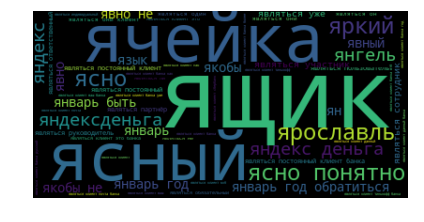

In [14]:
wordcloud = WordCloud().generate_from_frequencies(tf_idf_model.vocabulary_)

# Display the generated image:
plt.figure() 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.tight_layout()
plt.show()

In [15]:
lm = LogisticRegression(#solver='newton-cg', 
                        #n_jobs=-1,
                        #solver='lbfgs',
                        penalty='l2',
                        #tol=0.000000001,
                        random_state=42,
                        C=10, 
                        max_iter=100000)

In [37]:
lm_params = {# 'penalty':['l1', 'l2'],
             'penalty':['l2'],
             'C':[ 1, 2, 5],
             'solver':['newton-cg', 'lbfgs',  'sag'],
            #'solver':['liblinear', 'saga'],
             'tol' : [0.1, 0.01, 0.001, 0.0001]
    
    
}
lm_search = GridSearchCV(estimator=lm, 
                         param_grid=lm_params, 
                         scoring ='accuracy', 
                         cv=StratifiedKFold(10), 
                         n_jobs=-1,
                         verbose=1)

In [38]:
lm_search_fitted = lm_search.fit(X=train_tf_idf_vec, y=pd.factorize(train.type)[0])

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  6.7min finished
C:\Users\Ravin\Anaconda2\envs\coursera_ds\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [19]:
lm_search_fitted.best_estimator_

LogisticRegression(C=2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=42, solver='warn',
          tol=0.001, verbose=0, warm_start=False)

In [20]:
pred_scores = cross_val_score(estimator=lm_search_fitted.best_estimator_, X=train_tf_idf_vec, y=pd.factorize(train_title_text.type)[0],
                scoring='accuracy',  
                cv=10, #stratified by default
                n_jobs=-1)
display(np.mean(pred_scores))

0.7119427664390046

In [21]:
predicts = lm_search_fitted.best_estimator_.predict(test_tf_idf_vec)
predicts_names = pd.factorize(train.type)[1][predicts]

Кредит                         0.542182
Вклад                          0.122182
Ипотека                        0.097818
Бизнес услуги                  0.080364
Обслуживание физ. и юр. лиц    0.061455
Дебетовая карта                0.046909
Реструктуризация               0.037091
Денежные переводы              0.010909
Инвестиционные продукты        0.001091
dtype: float64

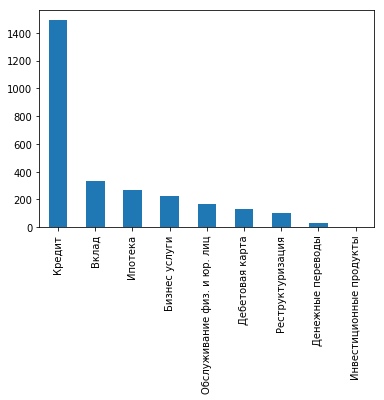

In [22]:
display(predicts_names.value_counts()/predicts_names.shape)
predicts_names.value_counts().plot.bar()

In [23]:
sub = pd.DataFrame({'index': range(0, len(predicts)),
                    'type': predicts_names})
sub.to_csv('class_answer.csv', index=False)

In [26]:
sub.head()

,index,type
0,0,Ипотека
1,1,Кредит
2,2,Кредит
3,3,Бизнес услуги
4,4,Кредит
